## Imports

In [129]:
#!pip install plotly

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.plotly as py
import plotly.tools as tls

tls.set_credentials_file(username='owencallen', api_key='QSH0OAhYDmgvVKQaZ11M')

## Load data

In [114]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
spray_df = pd.read_csv('../input/spray.csv')

## 1st look at DataFrames

In [115]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [116]:
train_df.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [117]:
train_df = train_df[['Date', 'Species', 'Trap', 'Latitude', 'Longitude','NumMosquitos', 'WnvPresent']]
train_df.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


In [118]:
test_df.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [119]:
test_df = test_df[['Date', 'Species', 'Trap', 'Latitude', 'Longitude']]
test_df.head()

,Date,Species,Trap,Latitude,Longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991


In [120]:
spray_df.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

In [121]:
spray_df = spray_df[['Date', 'Latitude', 'Longitude']]
spray_df.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [122]:
train_df.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent'],
      dtype='object')

In [123]:
train_df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Why are PIPIENS/RESTUANS not split?

In [107]:
train_df['Trap'].value_counts().head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

In [108]:
test_df['Trap'].value_counts().head()

T009    1528
T035    1520
T900    1468
T002     857
T008     822
Name: Trap, dtype: int64

In [130]:
dates = train_df['Date'].value_counts()

(array([17., 36., 30., 10.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  5. ,  59.6, 114.2, 168.8, 223.4, 278. , 332.6, 387.2, 441.8,
        496.4, 551. ]),
 <a list of 10 Patch objects>)

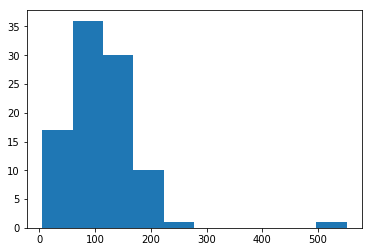

In [131]:
plt.hist(dates)

In [112]:
spray_df['Date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

## Time graph

## Plotly mapping function

In [109]:
def plotly_graph(df):
    data = [{
        'type' : 'scattergeo',
        'locationmode' : 'USA-states',
        'lon' : df['Longitude'],
        'lat' : df['Latitude'],
        'marker' : {
            'size' : 12,
            'autocolorscale' : False,
            'colorscale' : 'custom-colorscale',
            'color' : df['NumMosquitos'], #target being measured
            'colorbar' : {
                'title' : 'Mosquitos present'
            }
        }
    }]

    layout = {
        'title' : 'Species sightings in Chicago',
        'geo' : {
            'scope' : 'usa',
            'projection' : {'type' : 'albers usa'},
            'showland' : True,
            'landcolor' : 'rgb(250,250,250)',
            'subunitcolor' : 'rgb(210,210,210)',
            'contrycolor' : 'rgb(200,200,200)',
            'contrywidth' : 0.5, 
            'subunitwidth' : 0.5
        }
    }

    fig = {
        'data':data,
        'layout':layout
    }
    
    return fig

In [124]:
df = train_df[train_df['Date']=='2007-05-29']
fig = plotly_graph(df)
py.iplot(fig, validate = False, filename='d3-Species-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~owencallen/0 or inside your plot.ly account where it is named 'd3-Species-map'


In [126]:
df = train_df
fig = plotly_graph(df)
py.iplot(fig, validate = False, filename='d3-Species-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~owencallen/0 or inside your plot.ly account where it is named 'd3-Species-map'
